#### Задание

Цель: закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.  
Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.   
Этапы работы:   
1.Преобразуйте данные: проверьте наличие пропущенных значений.Преобразуйте/удалите пропуски по необходимости;
закодируйте категориальные переменные числовыми значениями по необходимости.   
2.Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.   
3.Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.   
4.Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.   
5.Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.   
6.Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.   
7.Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.   
8.*Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.
Сформулируйте выводы по проделанной работе:
как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
*Может ли ROC-кривая проходить ниже диагонали?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

#### 1. Загружаем данные в датасет 

In [140]:
df_athletes = pd.read_csv('athletes.csv')
df_athletes.head(5)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [141]:
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Отберем столбцы с числовыми значениями и найдем в них пропуски

In [142]:
df_numeric = df_athletes.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['id' 'height' 'weight' 'gold' 'silver' 'bronze']


In [143]:
for col in df_numeric.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0%
height - 3%
weight - 6%
gold - 0%
silver - 0%
bronze - 0%


Посмотрим распределение значений в столбцах с пропущенными данными 

(array([1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 1.700e+01, 3.800e+01, 1.190e+02, 1.850e+02, 4.290e+02,
        7.040e+02, 8.630e+02, 1.230e+03, 1.342e+03, 1.441e+03, 1.228e+03,
        1.169e+03, 8.320e+02, 6.560e+02, 5.590e+02, 3.000e+02, 1.860e+02,
        1.250e+02, 4.900e+01, 3.600e+01, 1.200e+01, 3.000e+00, 2.000e+00]),
 array([1.21      , 1.24333333, 1.27666667, 1.31      , 1.34333333,
        1.37666667, 1.41      , 1.44333333, 1.47666667, 1.51      ,
        1.54333333, 1.57666667, 1.61      , 1.64333333, 1.67666667,
        1.71      , 1.74333333, 1.77666667, 1.81      , 1.84333333,
        1.87666667, 1.91      , 1.94333333, 1.97666667, 2.01      ,
        2.04333333, 2.07666667, 2.11      , 2.14333333, 2.17666667,
        2.21      ]),
 <BarContainer object of 30 artists>)

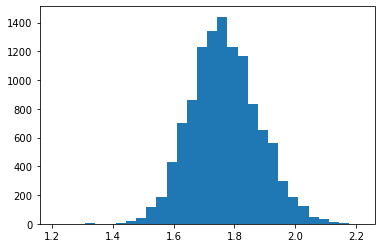

In [186]:
plt.hist(df_athletes['height'], bins=30)

(array([   7.,   16.,   55.,  334.,  756., 1045., 1416., 1411., 1813.,
        1244.,  846.,  789.,  558.,  384.,  345.,  193.,   57.,   57.,
          50.,   42.,   41.,   29.,   12.,   11.,    8.,    5.,    5.,
           5.,    2.,    2.]),
 array([ 31.        ,  35.63333333,  40.26666667,  44.9       ,
         49.53333333,  54.16666667,  58.8       ,  63.43333333,
         68.06666667,  72.7       ,  77.33333333,  81.96666667,
         86.6       ,  91.23333333,  95.86666667, 100.5       ,
        105.13333333, 109.76666667, 114.4       , 119.03333333,
        123.66666667, 128.3       , 132.93333333, 137.56666667,
        142.2       , 146.83333333, 151.46666667, 156.1       ,
        160.73333333, 165.36666667, 170.        ]),
 <BarContainer object of 30 artists>)

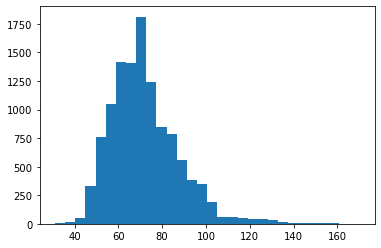

In [187]:
plt.hist(df_athletes['weight'], bins=30)

Столбцы имеют нормальное распределение , поэтому мы можем заменить пропущенные значения медианой 

In [146]:
df_athletes.loc[:, 'height'].fillna(df_athletes['height'].median(), inplace=True)
df_athletes['height'].unique()

array([1.72, 1.68, 1.98, 1.83, 1.81, 1.8 , 2.05, 1.93, 1.65, 1.7 , 1.75,
       1.76, 1.61, 1.78, 2.1 , 1.73, 1.85, 1.77, 1.9 , 1.86, 1.74, 1.6 ,
       2.07, 1.88, 1.66, 1.62, 1.87, 2.03, 1.69, 1.82, 1.89, 1.94, 1.95,
       1.71, 1.84, 1.91, 1.67, 2.02, 1.58, 1.63, 1.79, 1.97, 1.56, 1.55,
       1.57, 1.46, 1.92, 1.64, 1.53, 1.99, 1.96, 2.  , 2.04, 1.47, 1.52,
       2.01, 1.51, 1.59, 2.08, 1.37, 1.5 , 1.45, 2.06, 1.54, 2.11, 1.43,
       1.49, 1.33, 1.48, 1.44, 2.13, 2.09, 2.21, 2.18, 1.21, 1.38, 1.34,
       2.15, 2.17, 1.42, 1.4 , 2.14])

In [147]:
df_athletes.loc[:, 'weight'].fillna(df_athletes['weight'].median(), inplace=True)
df_athletes['weight'].unique()

array([ 64.,  56.,  79.,  80.,  71.,  67.,  98., 100.,  62.,  54.,  63.,
        66.,  70.,  49.,  68.,  57.,  88.,  65.,  72.,  75.,  95., 120.,
        90.,  60.,  73.,  84., 132.,  86.,  77.,  61.,  76.,  52.,  58.,
        81., 115., 130.,  92.,  94.,  93.,  85.,  82.,  55.,  78.,  83.,
        89.,  69.,  87.,  50., 105.,  53.,  47.,  59.,  51., 144.,  99.,
        48.,  44., 125.,  35.,  46.,  74., 113., 102.,  96., 107., 110.,
        97.,  45.,  91., 138., 136., 149.,  43., 117.,  42., 101., 114.,
       104., 122., 108.,  39., 140.,  37., 118., 135., 106., 170., 103.,
       139., 112., 109., 123.,  34., 128., 155.,  40., 145., 160., 127.,
       163.,  31., 137., 116., 119., 165.,  36., 133., 150., 148., 157.,
        41., 143., 111., 121., 126., 159., 152., 146., 124., 134., 142.,
       154.,  33.])

In [148]:
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11538 non-null  float64
 6   weight       11538 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Подготовим нашу выборку для модели. Отберем нужные для модели характеристики и запищем их в переменную X 

In [149]:
selectedColumns = df_athletes[['height', 'weight', 'sport', 'gold', 'silver', 'bronze']]
X = pd.get_dummies (selectedColumns, columns = ['sport'])
X.head(5)

,height,weight,gold,silver,bronze,sport_aquatics,sport_archery,sport_athletics,sport_badminton,sport_basketball,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1.72,64.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.81,71.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Целевую переменную "Пол" преобразуем с помощью LabelEncoder. И запишем ее в переменную y

In [150]:
le = LabelEncoder()
le.fit( df_athletes['sex'])

LabelEncoder()

In [151]:
y = pd.Series(le.transform(df_athletes['sex']))
y.head(5)

0    1
1    0
2    1
3    1
4    1
dtype: int32

#### 2. Разделим выборку на обучающую и тестовую

In [189]:
model = LogisticRegression(solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [192]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [243]:
predictions = model.predict_proba(X_test)

#### 3. Построим ROC-кривую с помощью функции sklearn.metrics. roc_curve

In [194]:
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1])

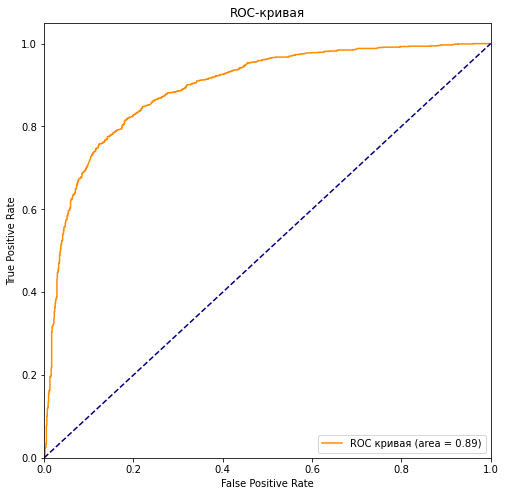

In [235]:
roc_auc = auc(fpr, tpr)
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#### 4. Находим значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [196]:
roc_auc_score( y_test, predictions[:, 1] )

0.8928753407410963

#### 5. Реализуем подсчет метрик TPR, FPR без специальных библиотек 

In [224]:
tpr2 = []
fpr2 = []
precision2 = []
recal2 = []
for threshold in np.arange(0,1,0.01):
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    y_pred = model.predict_proba( X_test )
    for predicted_prob, actual in zip( y_pred[:,1], y_test ):    
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0
        
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    tpr2.append(tp/(tp+fn))
    fpr2.append(fp/(fp+tn))
    precision2.append(tp / (tp + fp))
    recal2.append(tp / (tp + fn))


#### 6. Построим ROC кривую по рассчитанным характеристикам

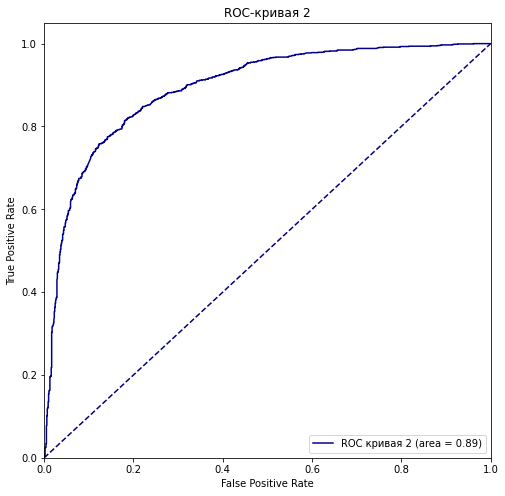

In [236]:
# print('Площадь, рассчитанная ручным способом: ', metrics.auc(fpr2, tpr2))
roc_auc2 = auc(fpr2, tpr2)
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(fpr, tpr, color='darkblue',
         label='ROC кривая 2 (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая 2')
plt.legend(loc="lower right")
plt.show()

Объединим 2 полученных графика в один 

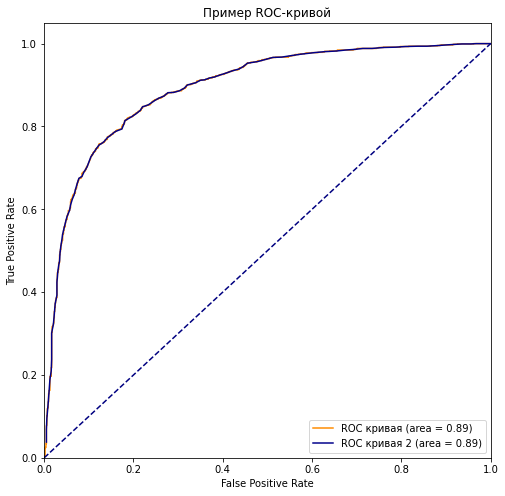

In [237]:
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)

plt.rcParams["figure.figsize"] = (8,8)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkblue',
         label='ROC кривая 2 (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

Вывод: Кривые практически не отличаются. 

#### 7. Построим график Precision-Recall, используя метрики, посчитанные в п. 5

(0.0, 1.0)

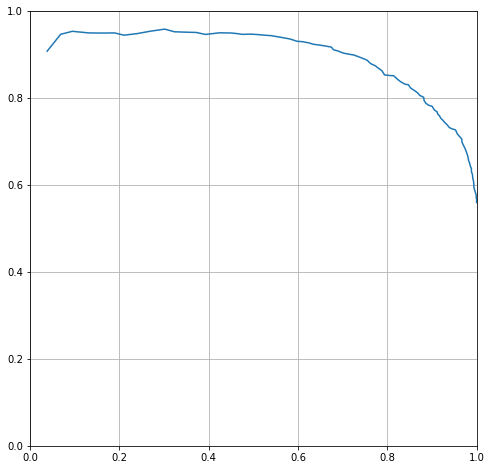

In [238]:
plt.plot(recal2, precision2)
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)

Сравним с грайифок полученным с помощью специальных библиотек 

In [239]:
pr, re, thres = precision_recall_curve( y_test, predictions[:, 1] )

(0.0, 1.0)

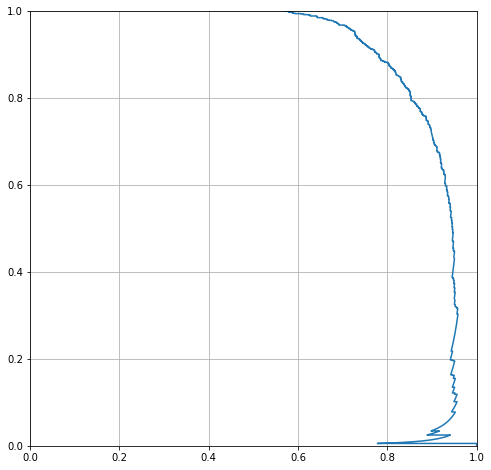

In [240]:
plt.plot(pr,re)
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)

#### 8. Вычислим значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [241]:
auc( fpr, tpr )

0.8928753407410963

In [242]:
auc( fpr2, tpr2 )

0.8927759460206695